# News Mood
## Analysis:
- The last 100 tweets for CBS were the most positive in the sentiment analysis.
- The New York Times is the most neutral in their last 100 tweets.
- Many of the tweets came through with a score of zero (completely neutral).  Looking at those tweets, it seems that they are complete fact and no opinion which may lead to their neutral score
- When the news organizations posted anything outside of factual statements, the compound score trend was either > 0.25 or < -0.25; either significantly positive or significantly negative.

In [1]:
# Dependencies
import tweepy
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
from config import (consumer_key, consumer_secret, access_token, access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

## Sentiment Analysis of Media Tweets

In [2]:
# Target Account
target_users = ["@BBC","@CBS","@CNN","@FoxNews","@nytimes"]

# Create an empty DataFrame for desired lists of values
tweet_data = {"Screen Name" : [],
             "Date": [],
             "Tweet Text": [],
             "Compound": [],
             "Positive": [],
             "Negative": [],
             "Neutral": [], 
             "Tweets Ago": []}

for user in target_users:
    # Counter
    counter = 1

    # Variables for holding sentiments
    sentiments = []

    # Variable for max_id
    oldest_tweet = None

    # Loop through 5 pages of tweets (total 100 tweets)
    for x in range(5):

        # Get all tweets from home feed
        public_tweets = api.user_timeline(user, page=x)

        # Loop through all tweets 
        for tweet in public_tweets:
            
            # Add to counter 
            counter += 1
            
            # Run Vader Analysis on each tweet
            account = tweet["user"]["screen_name"]
            date = tweet["created_at"]
            text = tweet["text"]
            results = analyzer.polarity_scores(tweet["text"])
            compound = results["compound"]
            pos = results["pos"]
            neg = results["neg"]
            neu = results["neu"]
            tweets_ago = counter

            # Get Tweet ID, subtract 1, and assign to oldest_tweet
            oldest_tweet = tweet['id'] - 1
            
            # Append tweet info to df
            tweet_data["Screen Name"].append(account)
            tweet_data["Date"].append(date)
            tweet_data["Tweet Text"].append(text)
            tweet_data["Compound"].append(compound)
            tweet_data["Positive"].append(pos)
            tweet_data["Negative"].append(neg)
            tweet_data["Neutral"].append(neu)
            tweet_data["Tweets Ago"].append(tweets_ago)
            


In [3]:
# Create dataframe data
tweet_df = pd.DataFrame(tweet_data, columns = ["Screen Name", "Date", "Tweet Text","Compound", "Positive", "Negative", "Neutral", "Tweets Ago"]).set_index("Screen Name").round(3)
tweet_df.head()

,Date,Tweet Text,Compound,Positive,Negative,Neutral,Tweets Ago
Screen Name,,,,,,,
BBC,Mon Apr 09 18:04:06 +0000 2018,When doctors found a large tumour on little Po...,-0.077,0.000,0.064,0.936,2
BBC,Mon Apr 09 17:02:07 +0000 2018,Keep full and satisfied with these protein-fil...,0.718,0.273,0.000,0.727,3
BBC,Mon Apr 09 16:43:45 +0000 2018,RT @BBCScotland: The history behind #NationalU...,0.000,0.000,0.000,1.000,4
BBC,Mon Apr 09 16:34:07 +0000 2018,RT @BBCTwo: Can you guess the city? #TheCityAn...,0.000,0.000,0.000,1.000,5
BBC,Mon Apr 09 16:26:04 +0000 2018,The latest episode of @TheSimpsons has address...,0.000,0.000,0.000,1.000,6


In [4]:
# Reset index to city type
tweet_df = tweet_df.reset_index(level='Screen Name')

In [5]:
tweet_df.to_csv("NewsMood_data.csv")

## Tweet Sentiment Analysis Plot

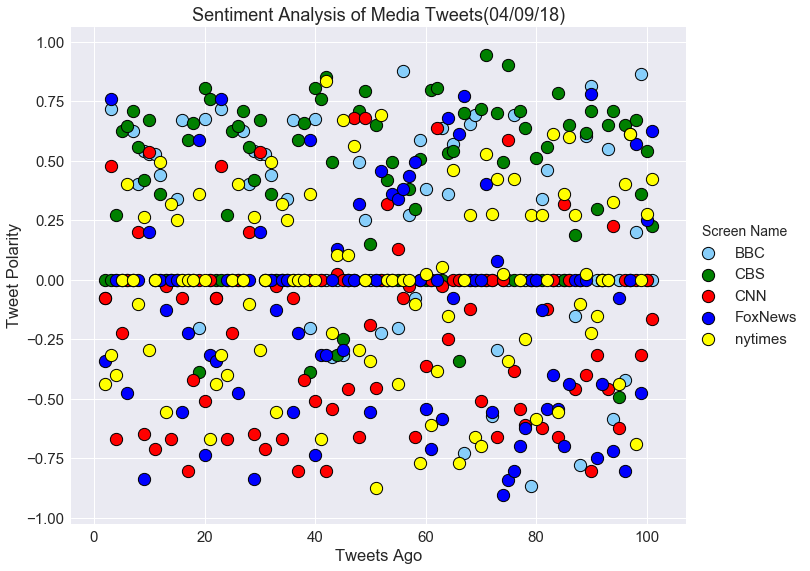

In [6]:
# Define font size
sns.set(font_scale=1.5)

# Define colors
col_list = ["lightskyblue", "green", "red", "blue", "yellow"]

tweet_plot = sns.lmplot(x='Tweets Ago', y='Compound', data=tweet_df, fit_reg=False, 
                   scatter_kws={'s':150,'alpha':1, 'linewidths':1, 'edgecolor':'k'}, 
                   legend_out=True, palette=dict(BBC=col_list[0], CBS=col_list[1], CNN=col_list[2], FoxNews=col_list[3], nytimes=col_list[4]),
                   hue = "Screen Name", size=8, aspect=1.25)

#Get today's date
date = datetime.now()
today = date.strftime("%m/%d/%y")

plt.title(f"Sentiment Analysis of Media Tweets({today})")
plt.ylabel("Tweet Polarity")

# Save plot as png
plt.savefig("tweet_sentiment.png")
plt.show()

## Overall Tweet Sentiments Plot

In [7]:
# Group dataframe by Screen Name to get aggregate data and calc mean
agg_pol = (tweet_df.groupby("Screen Name")["Compound"].agg(np.mean)).reset_index().round(3)
agg_pol

,Screen Name,Compound
0,BBC,0.151
1,CBS,0.349
2,CNN,-0.159
3,FoxNews,-0.100
4,nytimes,-0.012


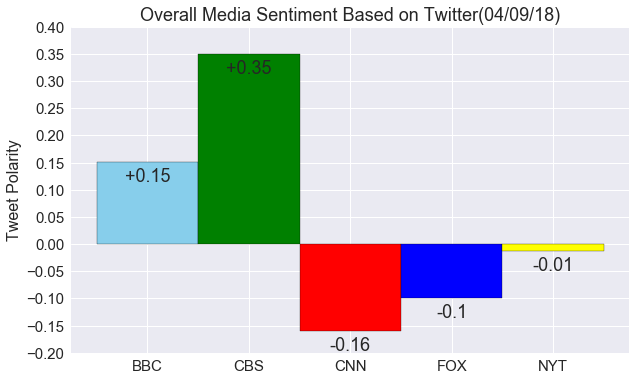

In [8]:
# Define screen name variables
BBC = agg_pol.loc[agg_pol["Screen Name"] == "BBC"]
CBS = agg_pol.loc[agg_pol["Screen Name"] == "CBS"]
CNN = agg_pol.loc[agg_pol["Screen Name"] == "CNN"]
Fox = agg_pol.loc[agg_pol["Screen Name"] == "FoxNews"]
NYT = agg_pol.loc[agg_pol["Screen Name"] == "nytimes"]

# Create a bar plot
plt.figure(figsize=(10,6))
x_labels = ["BBC", "CBS", "CNN", "FOX", "NYT"]
x_location = [value for value in np.arange(5)]
plt.xticks(x_location, x_labels)

plt.ylabel("Tweet Polarity", fontsize=16)
plt.ylim(-.20, .06)
plt.yticks(np.arange(-.20, 0.40, 0.05))

#Create bar plots for comparing the results of each Media Source's sentiment analysis
plt.bar(0, BBC["Compound"], color= "skyblue", edgecolor= "black", width= 1)
plt.bar(1, CBS["Compound"], color= "green", edgecolor= "black", width= 1)
plt.bar(2, CNN["Compound"], color= "red", edgecolor= "black", width= 1)
plt.bar(3, Fox["Compound"], color= "blue", edgecolor= "black", width= 1)
plt.bar(4, NYT["Compound"], color= "yellow", edgecolor= "black", width= 1)

# Set the title with today's date
plt.title(f"Overall Media Sentiment Based on Twitter({today})")

# Add sentiment values to bars
for index, row in agg_pol.iterrows():
    plt.text(index, row['Compound']-.01, '{:+}'.format(round(row['Compound'], 2)), ha="center", va='top')

# Save plot as png
plt.savefig("overall_sentiment.png")
plt.show()
